In [133]:
import numpy as np
from wLSM_utils import *
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed as ASE
from graspy.cluster import GaussianCluster as GCLUST
import matplotlib.pyplot as plt

%matplotlib inline

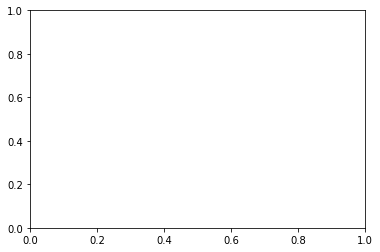

In [134]:
xs = np.arange(0,1,step=0.01)
fig, ax = plt.subplots(1,1)

In [135]:
def generate_cyclops(X, n, pi, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    density = np.random.uniform
    params = [0,1]
    
    counts = np.random.multinomial(n, [pi, 1 - pi]).astype(int)
    
    U = sample(counts[0], density, params)
    X_HW = get_latent_positions(U)
    X = X[:, np.newaxis].T
    
    All_X = np.concatenate((X_HW, X), axis = 0)
    
    P = All_X @ All_X.T
    
    A = sbm(np.concatenate((np.ones(counts[0]).astype(int), [counts[1]])), P)
    
    return A, counts

In [145]:
X = np.array([0.2, 0.2, 0.2])
n = 1000
pi = 0.9

A, counts = generate_cyclops(X, n, pi)
c = ['b']*counts[0]
c += ['r']*counts[1]

In [146]:
ase = ASE(n_components=3)
X_hat = ase.fit_transform(A)

<IPython.core.display.Javascript object>


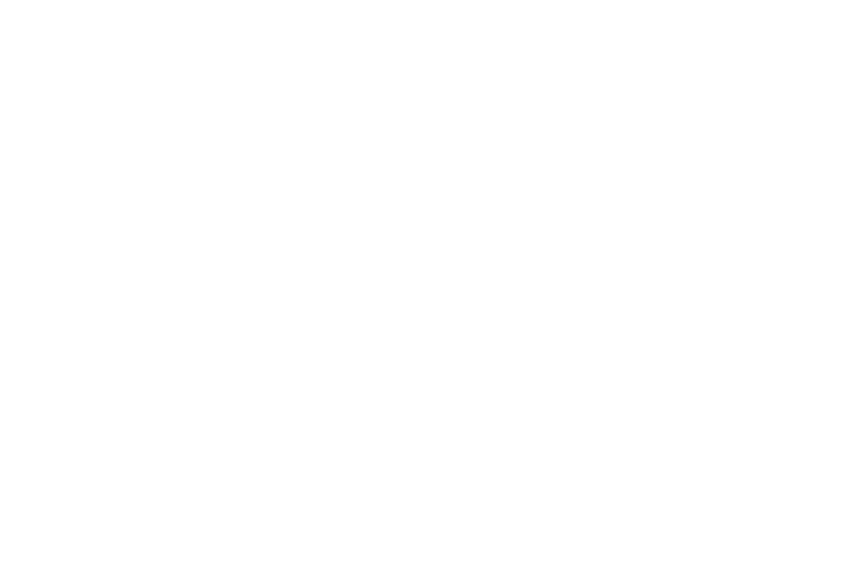

In [147]:
fig, ax = plt.subplots(1,1)
ax.scatter(X_hat[:,0], X_hat[:,1])
%matplotlib notebook

<IPython.core.display.Javascript object>


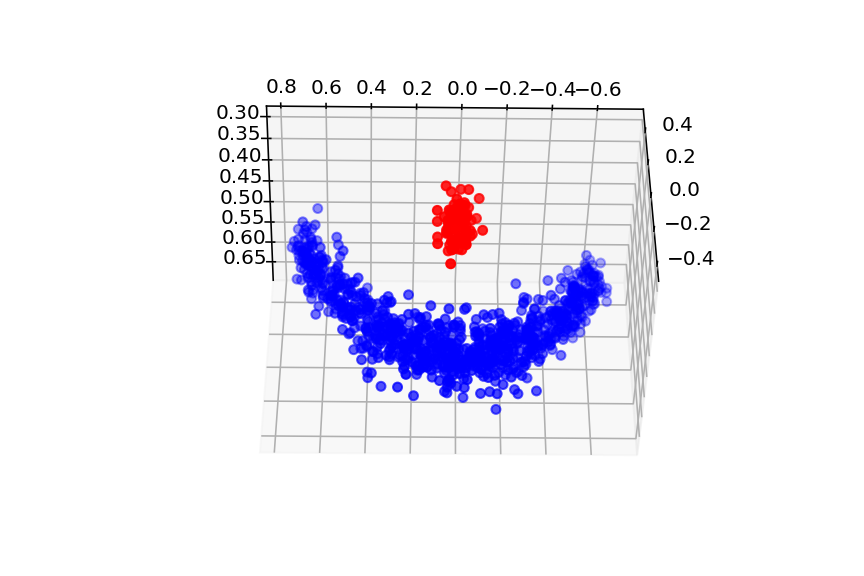

In [150]:

from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=c)
plt.savefig('truth.png')

<IPython.core.display.Javascript object>


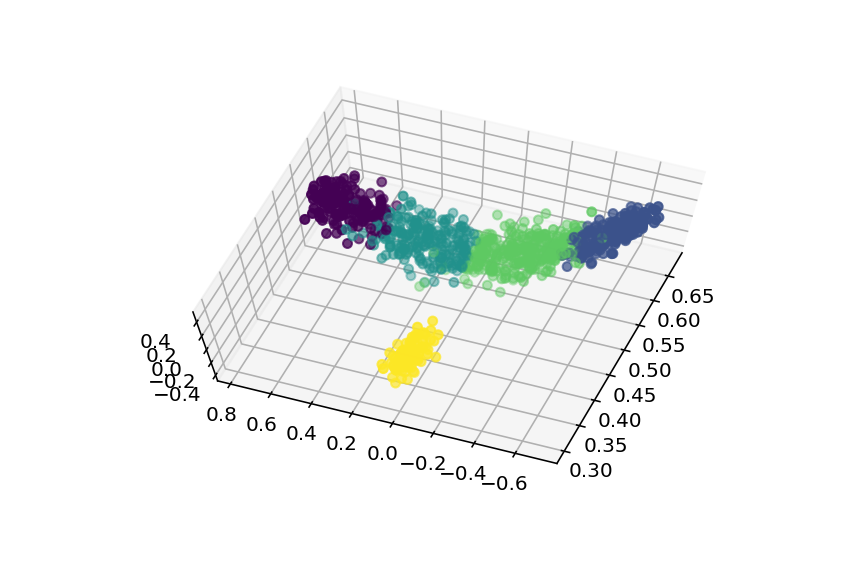

In [149]:
gclust = GCLUST(min_components=8)
c_hat = gclust.fit_predict(X_hat)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=c_hat)
plt.savefig('estimated.png')

In [91]:
from itertools import combinations
unique_labels = np.unique(c_hat)

for k in range(len(unique_labels)):
    for combo in list(combinations(np.unique(c_hat), k+1)):
        print(combo)
        

(0,)
(1,)
(2,)
(3,)
(0, 1)
(0, 2)
(0, 3)
(1, 2)
(1, 3)
(2, 3)
(0, 1, 2)
(0, 1, 3)
(0, 2, 3)
(1, 2, 3)
(0, 1, 2, 3)


In [93]:
np.polyfit(X_hat[:, 0], X_hat[:,1:], deg = 1)

array([[-0.36917793,  0.01679766],
       [ 0.20916012, -0.00951682]])

In [152]:
def func(data, a, b, c):
    return a*(data[:, 0])**2 + b*data[:, 1]**2 + c
#     return a*(data[:, 0]+data[:,1])**2 + c

In [153]:
import scipy.optimize as optimize
guess = (1,1,1)
params, pcov = optimize.curve_fit(func, X_hat[:, :2], X_hat[:, 2], guess)

In [154]:
def fitted_quadratic(data, params):
    return params[0]*data[0]**2 + params[1]*data[1]**2 + params[2]
#     return params[0]*(data[0] + data[1])**2 + params[1]

In [155]:
Z = np.zeros(n)

for i in range(n):
    Z[i] = fitted_quadratic(X_hat[i, :2], params)

<IPython.core.display.Javascript object>


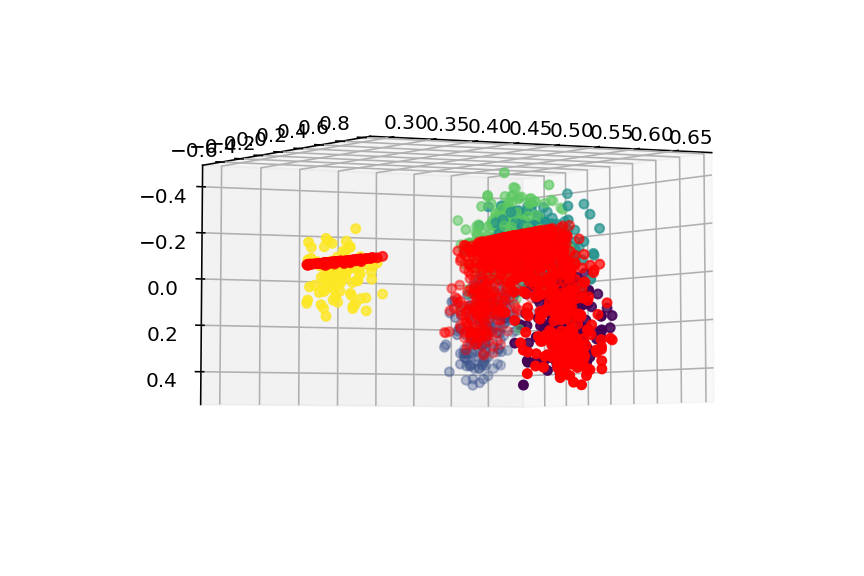

0.0926296485531578

In [156]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], Z, c=['r']*n)
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:,2], c=c_hat)

np.std(Z - X_hat[:,2], ddof = 1)